In [2]:
from pandas import read_excel
from pandas import ExcelFile
import geopandas as gpd
import matplotlib.pyplot as plt
import zipfile
import urllib.request
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [3]:
xlsx = ExcelFile('/g/data/xe2/ya6227/NVTAnalysis/data/NVT.xlsx')
df = xlsx.parse('Cereals')
df_wheat = df[df['Crop.Name'] == 'Wheat']

In [3]:
xlsx.sheet_names

['Cereals', 'Pulses', 'Canola']

In [4]:
df = xlsx.parse('Cereals')

In [5]:
df_wheat = df[df['Crop.Name'] == 'Wheat']

In [6]:
df_wheat.columns

Index(['Year', 'Crop.Name', 'State', 'RegionName', 'SiteDescription',
       'TrialCode', 'SeriesName', 'Company.Name', 'Orientation',
       'Trial GPS Lat', 'Trial GPS Long', 'SowingDate', 'HarvestDate',
       'Released', 'Abandoned', 'METInclude', 'StatusID', 'VarietyDisplayName',
       'CropTypeName', 'Single Site Yield', 'Yield Mean', 'CV',
       'Standard Error Difference', 'Standard Error', 'Weighting', 'F-value',
       'Probability', 'Error Mean Squared', '1000 grain weight',
       '% Cracked Grain in Screenings', 'Grain Brightness (Colour)',
       'Grain Moisture Content', 'Protein',
       'Retention (Screenings >2_5 mm sieve)', 'Screenings (<2_0mm sieve)',
       'Screenings (<2_2mm sieve)', 'Screenings WA (<2_5mm sieve)',
       'Test Weight'],
      dtype='object')

In [7]:
df_wheat = df_wheat.dropna(subset=['Trial GPS Lat', 'Trial GPS Long'])

In [8]:
gdf = gpd.GeoDataFrame(df_wheat, geometry=gpd.points_from_xy(df_wheat['Trial GPS Long'], df_wheat['Trial GPS Lat']), crs="EPSG:4326")


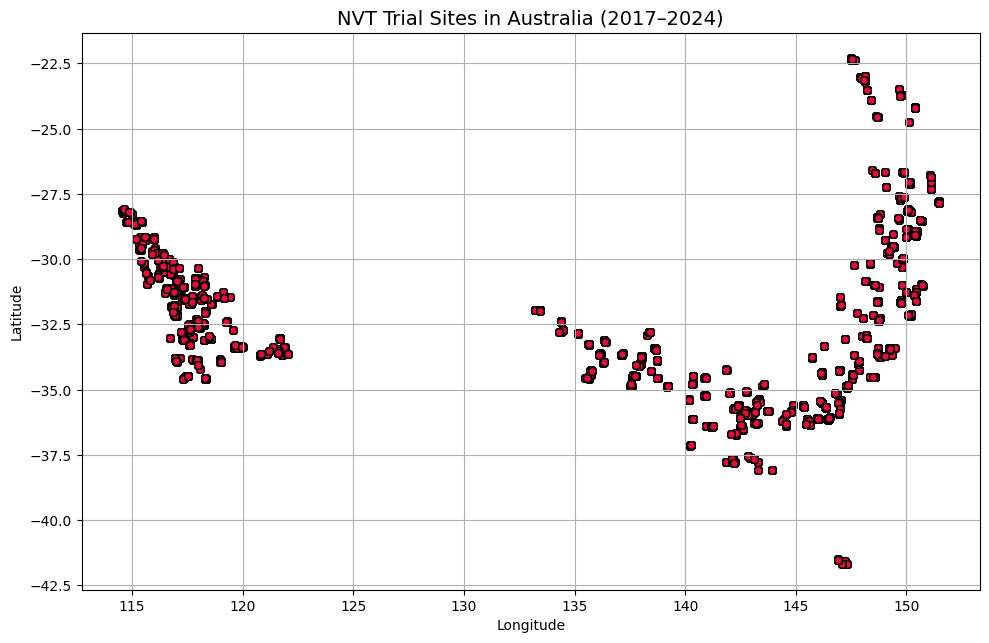

In [9]:
fig, ax = plt.subplots(figsize=(10, 12))
gdf.plot(ax=ax, markersize=30, color='crimson', alpha=0.7, edgecolor='k')

ax.set_title("NVT Trial Sites in Australia (2017–2024)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.tight_layout()

plt.show()

In [10]:
aus_states = gpd.read_file("/g/data/xe2/ya6227/NVTAnalysis/data/gadm41_AUS_1.shp")

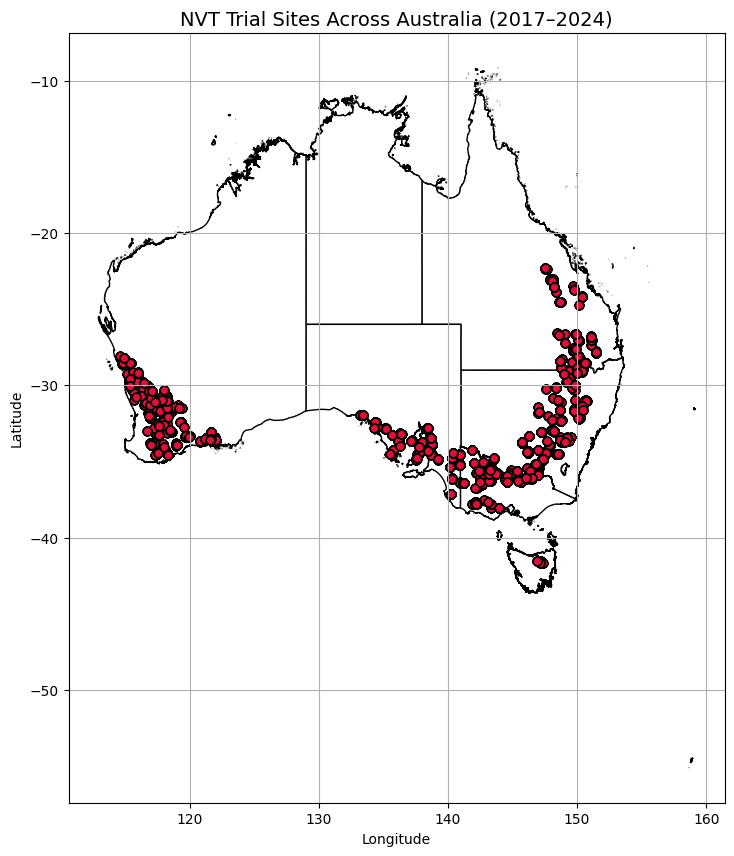

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
aus_states.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, color='crimson', edgecolor='black', alpha=0.7)

ax.set_title("NVT Trial Sites Across Australia (2017–2024)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.show()


/jobfs/146614238.gadi-pbs/ipykernel_439568/3064051077.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("tab20", num_regions)  # You can also try "hsv" or "tab20b"


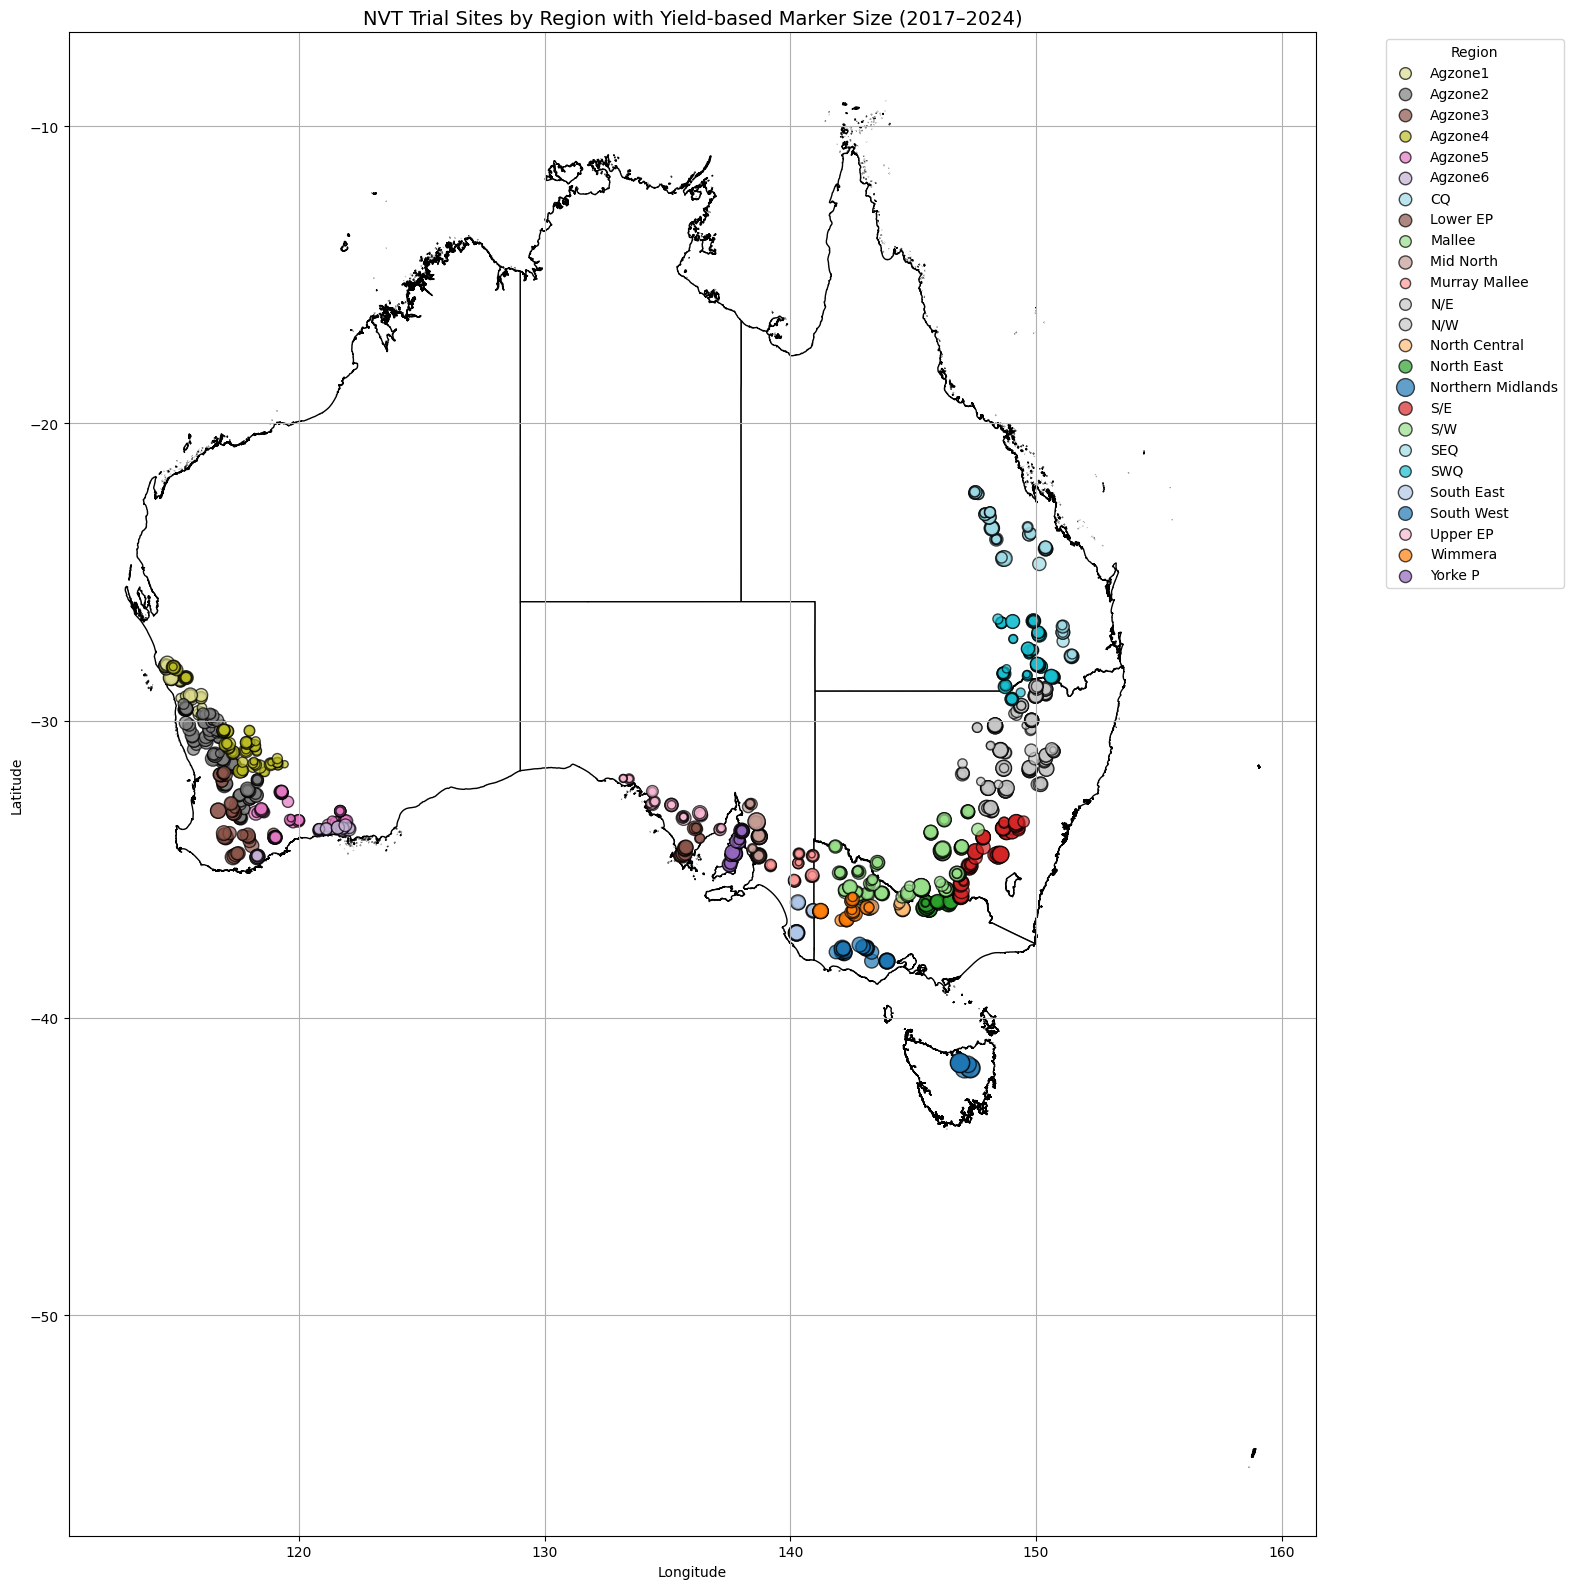

In [12]:
gdf_filtered = gdf.dropna(subset=["Single Site Yield", "RegionName"])

# Group by GPS + Region to get average yield per site
gdf_grouped = (
    gdf_filtered.groupby(["Trial GPS Lat", "Trial GPS Long", "RegionName"])
    .agg({
        "Single Site Yield": "mean",
        "geometry": "first"
    })
    .reset_index()
)

# Convert back to GeoDataFrame
gdf_grouped = gpd.GeoDataFrame(gdf_grouped, geometry="geometry", crs="EPSG:4326")

# Normalize marker size
min_size, max_size = 20, 200
yield_min = gdf_grouped["Single Site Yield"].min()
yield_max = gdf_grouped["Single Site Yield"].max()
gdf_grouped["marker_size"] = gdf_grouped["Single Site Yield"].apply(
    lambda y: min_size + (y - yield_min) / (yield_max - yield_min) * (max_size - min_size)
)


unique_regions = gdf_grouped["RegionName"].unique()
num_regions = len(unique_regions)
colormap = cm.get_cmap("tab20", num_regions)  # You can also try "hsv" or "tab20b"

# Create region → color map using hex codes
region_colors = {
    region: mcolors.to_hex(colormap(i)) for i, region in enumerate(unique_regions)
}

# Plot
fig, ax = plt.subplots(figsize=(16, 16))
aus_states.plot(ax=ax, color='white', edgecolor='black')

for region, group in gdf_grouped.groupby("RegionName"):
    group.plot(
        ax=ax,
        color=region_colors[region],
        markersize=group["marker_size"],
        edgecolor="black",
        alpha=0.7,
        label=region
    )

ax.set_title("NVT Trial Sites by Region with Yield-based Marker Size (2017–2024)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
varieties = df_wheat['VarietyDisplayName'].unique().tolist()

In [14]:
variety_counts = {}
for variety in varieties:
    variety_counts[variety] = df_wheat[df_wheat['VarietyDisplayName'] == variety].shape[0]

In [32]:
sorted_variety_counts = dict(sorted(variety_counts.items(), key=lambda item: item[1], reverse=True))

In [34]:
sorted_variety_counts

{'Catapult': 1079,
 'RockStar': 1048,
 'Cutlass': 1030,
 'Scepter': 997,
 'Vixen': 909,
 'LRPB Trojan': 882,
 'Yitpi': 816,
 'Sheriff CL Plus': 764,
 'Chief CL Plus': 748,
 'Razor CL Plus': 744,
 'EG Titanium': 738,
 'Mace': 674,
 'Valiant CL Plus': 667,
 'Denison': 624,
 'Beckom': 602,
 'Calibre': 598,
 'Emu Rock': 596,
 'Coolah': 586,
 'LRPB Flanker': 569,
 'Coota': 550,
 'EGA Gregory': 549,
 'Brumby': 543,
 'Hammer CL Plus': 517,
 'LRPB Havoc': 507,
 'Ballista': 503,
 'RGT Zanzibar': 469,
 'LRPB Cobra': 461,
 'Sunblade CL Plus': 461,
 'Boree': 440,
 'Devil': 439,
 'Kinsei': 430,
 'Zen': 429,
 'EG Jet': 424,
 'DS Faraday': 424,
 'LRPB Anvil CL Plus': 416,
 'Corack': 394,
 'LRPB Reliant': 391,
 'Sunmaster': 384,
 'Borlaug 100': 380,
 'Magenta': 379,
 'LRPB Raider': 376,
 'Suntop': 373,
 'LRPB Oryx': 372,
 'LRPB Lancer': 363,
 'Illabo': 361,
 'Grenade CL Plus': 358,
 'Ninja': 357,
 'LRPB Nighthawk': 353,
 'Longsword': 348,
 'Elmore CL Plus': 347,
 'DS Pascal': 332,
 'EGA Wedgetail': 33

In [20]:
df_rockstar = df_wheat[df_wheat['VarietyDisplayName'] == 'RockStar']

In [21]:
df_rockstar

,Year,Crop.Name,State,RegionName,SiteDescription,TrialCode,SeriesName,Company.Name,Orientation,Trial GPS Lat,...,1000 grain weight,% Cracked Grain in Screenings,Grain Brightness (Colour),Grain Moisture Content,Protein,Retention (Screenings >2_5 mm sieve),Screenings (<2_0mm sieve),Screenings (<2_2mm sieve),Screenings WA (<2_5mm sieve),Test Weight
11344,2018,Wheat,SA,Lower EP,Cummins,WMaA18CUMM5,Main Season,NVT,Unspecified,-34.303480,...,46.04,NaN,NaN,11.4,8.5,NaN,1.04,NaN,NaN,82.9
11376,2018,Wheat,SA,Lower EP,Rudall,WMaA18RUDA5,Main Season,NVT,Unspecified,-33.629920,...,46.38,NaN,NaN,11.7,11.9,NaN,0.36,NaN,NaN,80.5
11407,2018,Wheat,SA,Lower EP,Wanilla,WMaA18WANI5,Main Season,NVT,Unspecified,-34.584060,...,43.12,NaN,NaN,10.4,10.1,NaN,0.87,NaN,NaN,81.5
11445,2018,Wheat,SA,Mid North,Mintaro,WMaA18MINT5,Main Season,NVT,Unspecified,-33.863873,...,35.18,NaN,NaN,11.0,11.7,NaN,1.55,NaN,NaN,79.8
11492,2018,Wheat,SA,Mid North,Spalding,WMaA18SPAL5,Main Season,NVT,Unspecified,-33.465415,...,37.97,NaN,NaN,11.3,11.5,NaN,0.88,NaN,NaN,80.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65067,2024,Wheat,WA,Agzone5,Varley,WMaA24VARL6,Main Season,NVT,Unspecified,-32.725910,...,34.00,2.0,NaN,10.5,8.8,NaN,3.50,NaN,NaN,74.9
65096,2024,Wheat,WA,Agzone6,Gibson,WEBA24GIBS6,Early Break,NVT,Unspecified,-33.595086,...,45.00,20.0,NaN,12.1,8.8,NaN,0.80,NaN,NaN,77.7
65120,2024,Wheat,WA,Agzone6,Gibson,WMaA24GIBS6,Main Season,NVT,Unspecified,-33.595091,...,39.00,10.0,NaN,11.3,9.5,NaN,2.00,NaN,NaN,74.4
65151,2024,Wheat,WA,Agzone6,Stirlings South,WEBA24ST.S6,Early Break,NVT,Unspecified,-34.555000,...,45.79,NaN,NaN,11.4,12.8,NaN,1.16,NaN,NaN,89.0


In [47]:
df_rockstar['SeriesName'].unique()

array(['Main Season', 'Early Season', 'Long Season', 'Early Break'],
      dtype=object)

In [48]:
df_rockstar['SiteDescription'].unique()

array(['Cummins', 'Rudall', 'Wanilla', 'Mintaro', 'Spalding',
       'Turretfield', 'Geranium', 'Nangari', 'Palmer', 'Pinnaroo',
       'Wanbi', 'Wunkar', 'Conmurra', 'Keith', 'Wolseley', 'Kimba',
       'Minnipa', 'Mitchellville', 'Nunjikompita', 'Penong', 'Piednippie',
       'Warramboo', 'Maitland', 'Paskeville', 'Wokurna', 'Carnamah',
       'Eradu', 'Mingenew', 'Morawa', 'Nabawa', 'Ogilvie', 'Ballidu',
       'Beverley', 'Bolgart', 'Buntine', 'Coorow', 'Corrigin',
       'Cunderdin', 'Dandaragan', 'Eneabba', 'Goomalling', 'Kulin',
       'Miling', 'Narembeen', 'Wagin', 'Yealering', 'Gnowangerup',
       'Kendenup', 'Kojonup', 'Narrogin', 'York', 'Bencubbin', 'Cadoux',
       'Kalannie', 'Kellerberrin', 'Merredin', 'Moorine Rock',
       'Mukinbudin', 'Mullewa', 'Wyalkatchem', 'Yuna', 'Hyden',
       'Lake Grace', 'Mt. Madden', 'Salmon Gums', 'Scaddan', 'Gibson',
       'Munglinup', 'Canowindra', 'Galong', 'Gerogery', 'Quandialla',
       'Temora', 'Wagga Wagga', 'Beckom', 'Condobo

In [49]:
df_rockstar['Yield Mean'].max()

np.float64(8.96821961624967)

In [50]:
df_rockstar['Yield Mean'].min()

np.float64(0.100448035620736)

<Axes: >

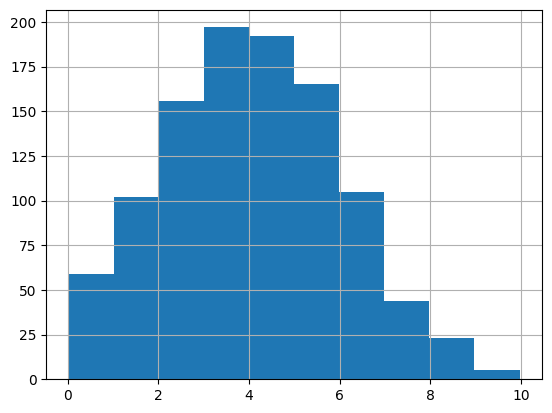

In [53]:
df_rockstar['Single Site Yield'].hist()

<Axes: >

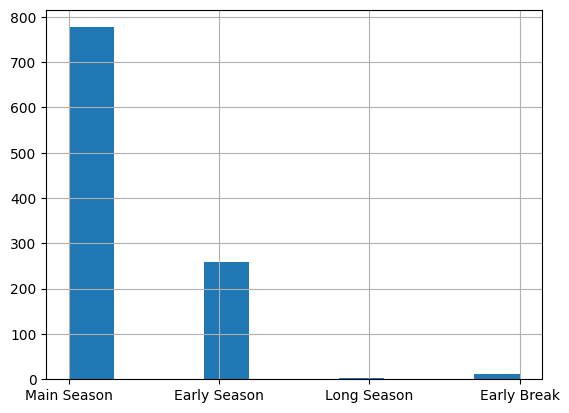

In [55]:
df_rockstar['SeriesName'].hist()

In [56]:
df_rockstar

,Year,Crop.Name,State,RegionName,SiteDescription,TrialCode,SeriesName,Company.Name,Orientation,Trial GPS Lat,...,1000 grain weight,% Cracked Grain in Screenings,Grain Brightness (Colour),Grain Moisture Content,Protein,Retention (Screenings >2_5 mm sieve),Screenings (<2_0mm sieve),Screenings (<2_2mm sieve),Screenings WA (<2_5mm sieve),Test Weight
11344,2018,Wheat,SA,Lower EP,Cummins,WMaA18CUMM5,Main Season,NVT,Unspecified,-34.303480,...,46.04,NaN,NaN,11.4,8.5,NaN,1.04,NaN,NaN,82.9
11376,2018,Wheat,SA,Lower EP,Rudall,WMaA18RUDA5,Main Season,NVT,Unspecified,-33.629920,...,46.38,NaN,NaN,11.7,11.9,NaN,0.36,NaN,NaN,80.5
11407,2018,Wheat,SA,Lower EP,Wanilla,WMaA18WANI5,Main Season,NVT,Unspecified,-34.584060,...,43.12,NaN,NaN,10.4,10.1,NaN,0.87,NaN,NaN,81.5
11445,2018,Wheat,SA,Mid North,Mintaro,WMaA18MINT5,Main Season,NVT,Unspecified,-33.863873,...,35.18,NaN,NaN,11.0,11.7,NaN,1.55,NaN,NaN,79.8
11492,2018,Wheat,SA,Mid North,Spalding,WMaA18SPAL5,Main Season,NVT,Unspecified,-33.465415,...,37.97,NaN,NaN,11.3,11.5,NaN,0.88,NaN,NaN,80.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65067,2024,Wheat,WA,Agzone5,Varley,WMaA24VARL6,Main Season,NVT,Unspecified,-32.725910,...,34.00,2.0,NaN,10.5,8.8,NaN,3.50,NaN,NaN,74.9
65096,2024,Wheat,WA,Agzone6,Gibson,WEBA24GIBS6,Early Break,NVT,Unspecified,-33.595086,...,45.00,20.0,NaN,12.1,8.8,NaN,0.80,NaN,NaN,77.7
65120,2024,Wheat,WA,Agzone6,Gibson,WMaA24GIBS6,Main Season,NVT,Unspecified,-33.595091,...,39.00,10.0,NaN,11.3,9.5,NaN,2.00,NaN,NaN,74.4
65151,2024,Wheat,WA,Agzone6,Stirlings South,WEBA24ST.S6,Early Break,NVT,Unspecified,-34.555000,...,45.79,NaN,NaN,11.4,12.8,NaN,1.16,NaN,NaN,89.0


<Axes: >

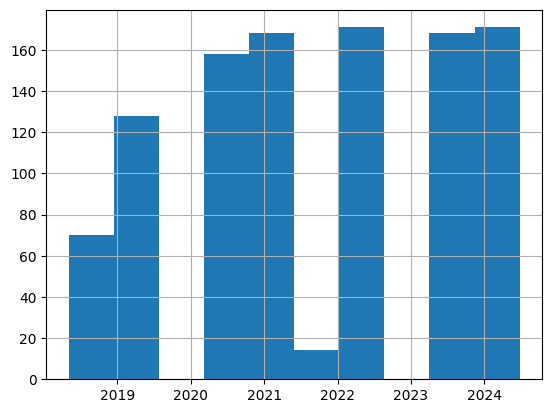

In [59]:
df_rockstar['SowingDate'].hist()

In [22]:
df_rockstar['SowingDate']

11344   2018-05-15
11376   2018-06-06
11407   2018-05-17
11445   2018-05-21
11492   2018-05-16
           ...    
65067   2024-06-04
65096   2024-04-25
65120   2024-06-04
65151   2024-04-14
65175   2024-05-05
Name: SowingDate, Length: 1048, dtype: datetime64[ns]

In [ ]:
df_rockstar_2018 = df_rockstar[df_rockstar['Year'] == 2018]

(array([17659., 17666., 17673., 17683., 17690., 17697., 17704.]),
 [Text(17659.0, 0, '2018-05-08'),
  Text(17666.0, 0, '2018-05-15'),
  Text(17673.0, 0, '2018-05-22'),
  Text(17683.0, 0, '2018-06-01'),
  Text(17690.0, 0, '2018-06-08'),
  Text(17697.0, 0, '2018-06-15'),
  Text(17704.0, 0, '2018-06-22')])

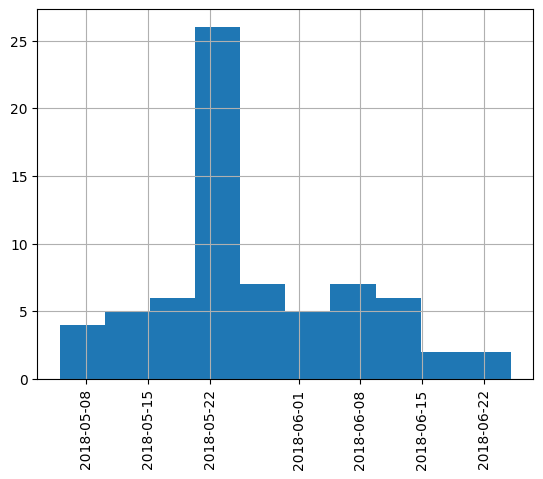

In [29]:
df_rockstar_2018['SowingDate'].hist()
plt.xticks(rotation='vertical')

(array([16801., 17167., 17532., 17897., 18262., 18628., 18993., 19358.,
        19723.]),
 [Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024')])

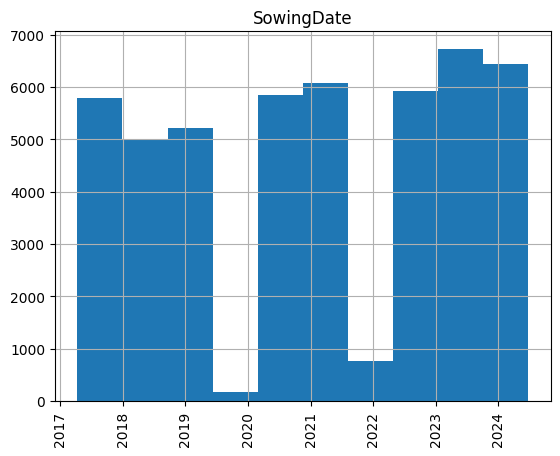

In [30]:
df_wheat.hist('SowingDate')
plt.xticks(rotation='vertical')

In [64]:
df_rockstar.columns

Index(['Year', 'Crop.Name', 'State', 'RegionName', 'SiteDescription',
       'TrialCode', 'SeriesName', 'Company.Name', 'Orientation',
       'Trial GPS Lat', 'Trial GPS Long', 'SowingDate', 'HarvestDate',
       'Released', 'Abandoned', 'METInclude', 'StatusID', 'VarietyDisplayName',
       'CropTypeName', 'Single Site Yield', 'Yield Mean', 'CV',
       'Standard Error Difference', 'Standard Error', 'Weighting', 'F-value',
       'Probability', 'Error Mean Squared', '1000 grain weight',
       '% Cracked Grain in Screenings', 'Grain Brightness (Colour)',
       'Grain Moisture Content', 'Protein',
       'Retention (Screenings >2_5 mm sieve)', 'Screenings (<2_0mm sieve)',
       'Screenings (<2_2mm sieve)', 'Screenings WA (<2_5mm sieve)',
       'Test Weight'],
      dtype='object')

In [68]:
df_rockstar

,Year,Crop.Name,State,RegionName,SiteDescription,TrialCode,SeriesName,Company.Name,Orientation,Trial GPS Lat,...,1000 grain weight,% Cracked Grain in Screenings,Grain Brightness (Colour),Grain Moisture Content,Protein,Retention (Screenings >2_5 mm sieve),Screenings (<2_0mm sieve),Screenings (<2_2mm sieve),Screenings WA (<2_5mm sieve),Test Weight
11344,2018,Wheat,SA,Lower EP,Cummins,WMaA18CUMM5,Main Season,NVT,Unspecified,-34.303480,...,46.04,NaN,NaN,11.4,8.5,NaN,1.04,NaN,NaN,82.9
11376,2018,Wheat,SA,Lower EP,Rudall,WMaA18RUDA5,Main Season,NVT,Unspecified,-33.629920,...,46.38,NaN,NaN,11.7,11.9,NaN,0.36,NaN,NaN,80.5
11407,2018,Wheat,SA,Lower EP,Wanilla,WMaA18WANI5,Main Season,NVT,Unspecified,-34.584060,...,43.12,NaN,NaN,10.4,10.1,NaN,0.87,NaN,NaN,81.5
11445,2018,Wheat,SA,Mid North,Mintaro,WMaA18MINT5,Main Season,NVT,Unspecified,-33.863873,...,35.18,NaN,NaN,11.0,11.7,NaN,1.55,NaN,NaN,79.8
11492,2018,Wheat,SA,Mid North,Spalding,WMaA18SPAL5,Main Season,NVT,Unspecified,-33.465415,...,37.97,NaN,NaN,11.3,11.5,NaN,0.88,NaN,NaN,80.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65067,2024,Wheat,WA,Agzone5,Varley,WMaA24VARL6,Main Season,NVT,Unspecified,-32.725910,...,34.00,2.0,NaN,10.5,8.8,NaN,3.50,NaN,NaN,74.9
65096,2024,Wheat,WA,Agzone6,Gibson,WEBA24GIBS6,Early Break,NVT,Unspecified,-33.595086,...,45.00,20.0,NaN,12.1,8.8,NaN,0.80,NaN,NaN,77.7
65120,2024,Wheat,WA,Agzone6,Gibson,WMaA24GIBS6,Main Season,NVT,Unspecified,-33.595091,...,39.00,10.0,NaN,11.3,9.5,NaN,2.00,NaN,NaN,74.4
65151,2024,Wheat,WA,Agzone6,Stirlings South,WEBA24ST.S6,Early Break,NVT,Unspecified,-34.555000,...,45.79,NaN,NaN,11.4,12.8,NaN,1.16,NaN,NaN,89.0


In [1]:
df_rockstar

NameError: name 'df_rockstar' is not defined

In [1]:
df_rockstar

NameError: name 'df_rockstar' is not defined

In [6]:
df_wheat['Single Site Yield']

2028     1.922930
2029     0.851638
2030     1.622017
2031     1.294284
2032     1.579052
           ...   
65191    3.471538
65192    3.446877
65193    3.769814
65194    3.564366
65195    3.460780
Name: Single Site Yield, Length: 48122, dtype: float64